# FCIQMC (Full Configuration Interaction Quantum Monte Carlo)

論文 [Fermion Monte Carlo without fixed nodes: A game of life, death, and
annihilation in Slater determinant space](https://2024.sci-hub.st/1534/f26924b07d1005f6f9a7be1b525feec7/booth2009.pdf) を読み、Pythonでの実装を試みる。

## 準備

```
$ conda install tqdm pandas
$ conda install -c conda-forge pyscf
```

## 共通の関数を定義

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyscf import gto, scf, fci, ao2mo
import random

rng = np.random.default_rng()

def build_hamiltonian(mol):
    elec_num = sum(mol.nelec)
    myhf = mol.HF()
    myhf.kernel()
    mymp2 = myhf.MP2()
    mymp2.kernel() # run mp2
    C = myhf.mo_coeff # molecular coefficient matrix
    h1 = np.matmul((C.T),np.matmul((myhf.get_hcore()),(C)))
    h2 = ao2mo.kernel(mol,C)
    h2 = ao2mo.restore(8,h2,mol.nao_nr())

    H_mat = fci.direct_spin1.pspace(h1, h2, mol.nao_nr(), elec_num, np=70000)[1] # creates Hamiltonian
    nspatorbs = int(mol.nao_nr())

    # --- フル FCI エネルギー ---
    cis = fci.FCI(myhf)
    E_fci, civec = cis.kernel(h1, h2, C.shape[1], mol.nelec)
    
    return H_mat, E_fci


def FCIQMC(mol, shift=0, init_n_walker=1, n_steps=15000, step_starting_shift_upd=2000, shift_upd_interval=10,
           dt=0.001, damping=0.05):
    """
    Full Configuration Interaction Quantum Monte Carlo (FCIQMC) を用いて
    H2 分子（R = 0.74 Å）の基底状態エネルギーを推定する。

    Args:
        shift: 初期シフト値 S(0)。ウォーカー数の増減を抑制するためのエネルギー的バイアス
        init_n_walker: 初期状態（参照決定基）に配置するウォーカー数
        n_steps: シミュレーションの総ステップ数
        step_starting_shift_upd: Shift の更新を開始するステップ。初期緩和期間としてこのステップまでは shift を固定する。
        shift_upd_interval: Shift をどの頻度で更新するか（ステップ単位）。例えば 10 なら、10 ステップごとに shift を更新する。
        dt: imaginary time step（時間刻み）。小さいほど安定するが計算コストが増える
        damping: Shift更新時の更新の程度表すパラメータ

    Returns:
        tuple:
            - **E_est (float)**: 最終 1000 ステップの projected energy の平均（推定エネルギー）
            - **hist_population (list[int])**: 各ステップのウォーカー総数の履歴
            - **hist_shift (list[float])**: 各ステップの shift の履歴
            - **hist_energy (list[float])**: 各ステップの projected energy の履歴
    """    
    H_mat, E_fci = build_hamiltonian(mol)
    print(f"--- FCI Matrix ---")
    print(H_mat.shape)
    print(H_mat)
    
    E_est = 0
    hist_population, hist_shift, hist_energy = [], [], []
    
    diag_H = np.diag(H_mat)    
    pre_shift = shift
    pre_pop = init_n_walker

    # 基底状態（Hartree-Fock解）のインデックスを特定
    # PySCFのFCIでは通常、最初の行列要素がHF状態に対応します
    ref_det_idx = 0 
        
    # ウォーカーの初期化 {det_index: signed_population}
    # 符号付き整数で管理（+1, -1など）
    walkers = {ref_det_idx: init_n_walker}

    print('\n---- Initial walkers ----')
    for k, v in walkers.items():
        tqdm.write(f"{v} walkers on {k}th determinant")

    
    for step in tqdm(range(n_steps)):
        new_walkers = {}
        
        # walkersが乗っている行列式の全てのインデックスを取得
        current_dets = list(walkers.keys())
        # if step % 1000 == 0:
        #     tqdm.write(f"current_dets: {current_dets}")

        
        for i in current_dets:
            n_i = walkers[i] # ith行列式上のウォーカー数（符号付き）
            if n_i == 0: continue

            # ----- Spawning Step -----
            # 通常は接続された決定基をランダムサンプリングするが、
            # ここでは行列が小さいため、接続している全 j を走査（簡単のため）
            row = H_mat[i]
            # 非ゼロ要素のインデックスを取得
            connected_dets = np.where(row != 0)[0]
            
            for j in connected_dets:
                # 対角要素は自分自身への遷移を表すので処理しない
                if i == j: continue
                h_ij = row[j]

                # Spawning probability: Ps = dt * |H_ij|
                # 生成される数: sign(walker) * sign(-H_ij)
                # TODO: 分母のpgenは1？
                prob_spawn = dt * abs(h_ij)

                # 全てのwalkerに対して、spawnを試みる
                for k in range(n_i):            
                    if rng.random() <= prob_spawn:
                        # print(f'prob_spawn from {i} to {j}th determinant: ', prob_spawn)
                        if j not in new_walkers: new_walkers[j] = 0

                        n_spawn = 1
                        if prob_spawn >= 1:
                            prob_spawn_frac, prob_spawn_int = math.modf(prob_spawn)
                            n_spawn = prob_spawn_int + int(rng.random() < prob_spawn_frac) # 小数部分の確率でもう一つwalkerを追加で生成する

                        # h_ij>0ならば親と異符号、h_ij<0ならば親と同符号のwalkerを遷移先jth行列式の上に生成
                        if h_ij > 0:
                            new_walkers[j] += -np.sign(n_i) * n_spawn
                        else:
                            new_walkers[j] += np.sign(n_i) * n_spawn

            # ----- Diagonal Step (Death/Cloning) -----
            # Pd = exp(-dt * (H_ii - S)) - 1  ~ -dt * (H_ii - S)
            h_ii = diag_H[i]
            prob_death = dt * (h_ii - shift)
            n_walker_on_D = n_i
            sign = np.sign(n_walker_on_D)

            for k in range(abs(n_i)):
                if rng.random() <= abs(prob_death):
                    if prob_death > 0:
                        # prob_deathが正ならwalkerを一つ消滅させる
                        n_walker_on_D = sign * (abs(n_walker_on_D) - 1)
                    else:
                        # prob_deathが負ならwalkerを一つ複製する
                        n_walker_on_D = sign * (abs(n_walker_on_D) + 1)
            walkers[i] = n_walker_on_D

        # ----- Annihilation Step -----
        for idx, n in new_walkers.items():
            walkers[idx] = walkers.get(idx, 0) + n

        # ---- Shift Update -----
        current_pop = sum(abs(w) for w in walkers.values())
        if step > step_starting_shift_upd: # 初期緩和後
            if step % shift_upd_interval == 0:
                shift = pre_shift - (damping / (shift_upd_interval*dt)) * np.log(current_pop / pre_pop)
                pre_shift = shift
        hist_shift.append(shift)
        pre_pop = current_pop
        hist_population.append(current_pop)
        
        # ----- Energy Estimation (Projected Energy) -----
        E_HF = diag_H[ref_det_idx]
        row0 = H_mat[ref_det_idx]
        num_ref = walkers.get(ref_det_idx, 0)
        E_proj = E_HF + sum(row0[idx]*v/num_ref for idx, v in walkers.items() if idx != ref_det_idx)
        # TODO: 論文にはない項を足している
        E_proj += mol.energy_nuc()
        hist_energy.append(E_proj)
        # TODO: singles/doublesに限定する？
        
        if step % 1000 == 0:
            tqdm.write(f"Step {step}: Walkers={current_pop}, Shift={shift:.5f}, E_proj={E_proj:.6f}")
            for k, v in walkers.items():
                tqdm.write(f"  {v} walkers on {k}th determinant")

    E_est = np.mean(hist_energy[-1000:]) # 最後の1000ステップの平均
    
    print('\n---- Walkers (result) ----')
    for k, v in walkers.items():
        print(f"{v} walkers on {k}th determinant")

    return E_est, E_fci, hist_population, hist_shift, hist_energy


def plot_result(hist_population, hist_shift, hist_energy):
    plt.figure(figsize=(10, 6))
    plt.plot(hist_population)
    plt.xlabel('Step')
    plt.ylabel('Population')
    plt.yscale('log')
    
    plt.figure(figsize=(10, 6))
    plt.plot(hist_shift)
    plt.xlabel('Step')
    plt.ylabel('Shift')
    
    plt.figure(figsize=(10, 6))
    plt.plot(hist_energy)
    plt.xlabel('Step')
    plt.ylabel('Projected Energy')
    
    plt.show()

## ${H_2}$ 分子 STO-3G

FCIによる基底エネルギーは -1.1373 で、FCIQMCによる推定基底エネルギーは近い値が出る。

--- FCI Matrix ---
(4, 4)
[[-1.83186365e+00 -3.63850793e-16 -3.63850793e-16  1.81210462e-01]
 [-3.63850793e-16 -1.06466723e+00  1.81210462e-01  1.90003444e-16]
 [-3.63850793e-16  1.81210462e-01 -1.06466723e+00  1.90003444e-16]
 [ 1.81210462e-01  1.90003444e-16  1.90003444e-16 -2.52486193e-01]]

---- Initial walkers ----
1 walkers on 0th determinant


 13%|███████████▊                                                                              | 1963/15000 [00:00<00:00, 19627.63it/s]

Step 0: Walkers=1, Shift=0.00000, E_proj=-1.116759
  1 walkers on 0th determinant
Step 1000: Walkers=13, Shift=0.00000, E_proj=-1.197297
  9 walkers on 0th determinant
  -4 walkers on 3th determinant
Step 2000: Walkers=46, Shift=0.00000, E_proj=-1.149284
  39 walkers on 0th determinant
  -7 walkers on 3th determinant


 26%|███████████████████████▊                                                                   | 3926/15000 [00:00<00:01, 5937.11it/s]

Step 3000: Walkers=220, Shift=-0.46731, E_proj=-1.143186
  192 walkers on 0th determinant
  -28 walkers on 3th determinant


 33%|██████████████████████████████▏                                                            | 4969/15000 [00:01<00:03, 2742.80it/s]

Step 4000: Walkers=634, Shift=-0.99132, E_proj=-1.141810
  557 walkers on 0th determinant
  -77 walkers on 3th determinant


 37%|█████████████████████████████████▉                                                         | 5593/15000 [00:02<00:05, 1859.24it/s]

Step 5000: Walkers=1183, Shift=-1.37846, E_proj=-1.141280
  1042 walkers on 0th determinant
  -141 walkers on 3th determinant


 42%|██████████████████████████████████████▏                                                    | 6293/15000 [00:03<00:06, 1245.57it/s]

Step 6000: Walkers=1611, Shift=-1.56475, E_proj=-1.135091
  1463 walkers on 0th determinant
  -148 walkers on 3th determinant


 48%|███████████████████████████████████████████▊                                                | 7147/15000 [00:04<00:11, 667.33it/s]

Step 7000: Walkers=2028, Shift=-1.64150, E_proj=-1.134517
  1847 walkers on 0th determinant
  -181 walkers on 3th determinant


 54%|█████████████████████████████████████████████████▊                                          | 8125/15000 [00:06<00:15, 453.60it/s]

Step 8000: Walkers=2383, Shift=-1.68198, E_proj=-1.133271
  2184 walkers on 0th determinant
  -199 walkers on 3th determinant


 61%|███████████████████████████████████████████████████████▋                                    | 9084/15000 [00:09<00:14, 400.36it/s]

Step 9000: Walkers=2727, Shift=-1.73892, E_proj=-1.136918
  2454 walkers on 0th determinant
  -273 walkers on 3th determinant


 67%|█████████████████████████████████████████████████████████████▎                             | 10111/15000 [00:11<00:13, 373.63it/s]

Step 10000: Walkers=2921, Shift=-1.78011, E_proj=-1.137732
  2618 walkers on 0th determinant
  -303 walkers on 3th determinant


 74%|███████████████████████████████████████████████████████████████████▎                       | 11104/15000 [00:14<00:11, 354.06it/s]

Step 11000: Walkers=3071, Shift=-1.79312, E_proj=-1.136088
  2775 walkers on 0th determinant
  -296 walkers on 3th determinant


 81%|█████████████████████████████████████████████████████████████████████████▍                 | 12101/15000 [00:17<00:08, 341.51it/s]

Step 12000: Walkers=3186, Shift=-1.81230, E_proj=-1.136571
  2872 walkers on 0th determinant
  -314 walkers on 3th determinant


 87%|███████████████████████████████████████████████████████████████████████████████▎           | 13080/15000 [00:20<00:05, 336.53it/s]

Step 13000: Walkers=3232, Shift=-1.82326, E_proj=-1.137435
  2901 walkers on 0th determinant
  -331 walkers on 3th determinant


 94%|█████████████████████████████████████████████████████████████████████████████████████▎     | 14068/15000 [00:23<00:02, 329.54it/s]

Step 14000: Walkers=3267, Shift=-1.83101, E_proj=-1.138294
  2920 walkers on 0th determinant
  -347 walkers on 3th determinant


100%|███████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [00:25<00:00, 577.43it/s]



---- Walkers (result) ----
2923 walkers on 0th determinant
-365 walkers on 3th determinant
------------------------------
FCI Energy: -1.137284 Ha
Final FCIQMC Energy: -1.138231 Ha


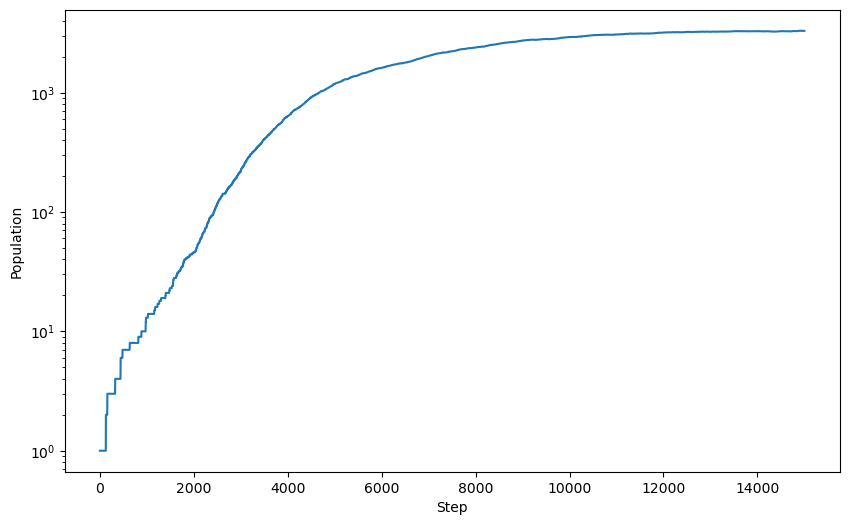

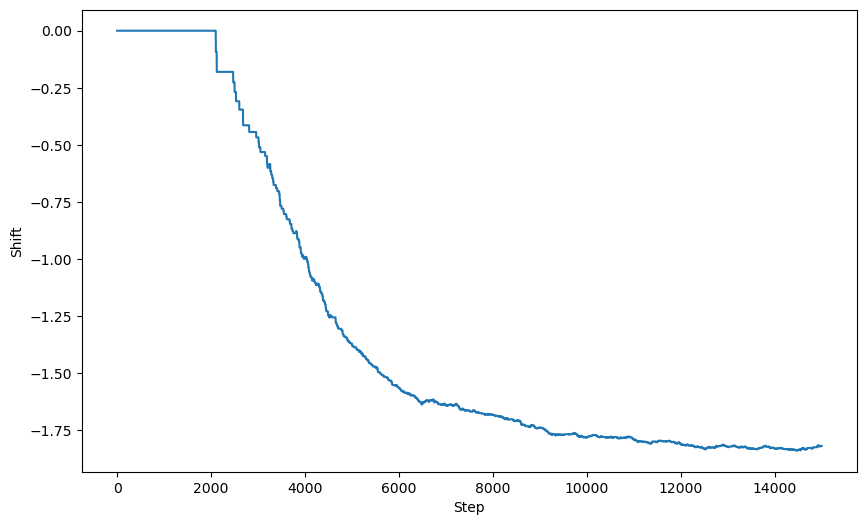

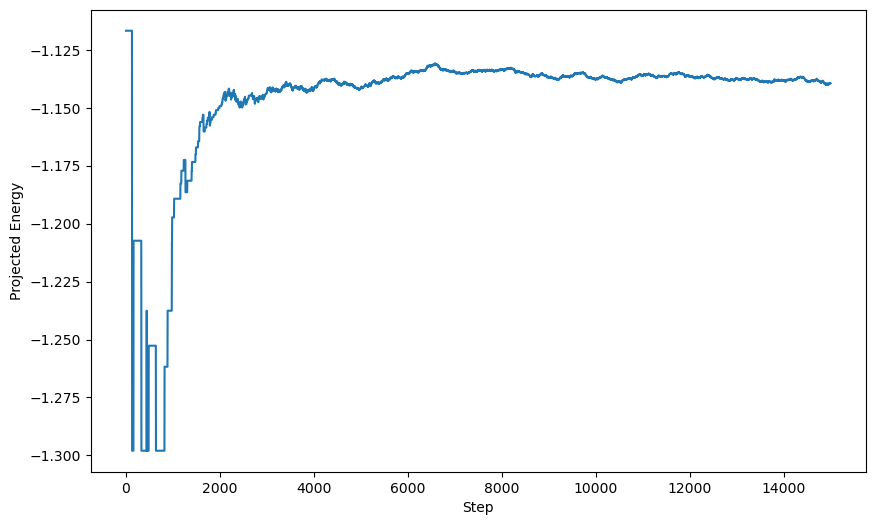

In [2]:
from pyscf import gto

# H2分子の定義 (0.74 Angstrom)
mol = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='sto-3g', verbose=0)
E_est, E_fci, hist_population, hist_shift, hist_energy = FCIQMC(mol)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} Ha")
plot_result(hist_population, hist_shift, hist_energy)


## ${H_3^+}$ (sto-3g)
FCI行列は9x9

converged SCF energy = -1.24591513197544
E(RMP2) = -1.26559786762945  E_corr = -0.0196827356540126
E(SCS-RMP2) = -1.26953441476026  E_corr = -0.0236192827848151
--- FCI Matrix ---
(9, 9)
[[-2.83347005e+00 -2.64353883e-17 -9.82897130e-09 -2.64353883e-17
   1.44076448e-01 -1.23431929e-17 -9.82897130e-09 -1.23431929e-17
   1.44076569e-01]
 [-2.64353883e-17 -2.20370352e+00 -5.82694530e-17  1.44076448e-01
   1.26036158e-12 -9.56437226e-02 -1.23431929e-17 -9.56440818e-02
  -1.26050035e-12]
 [-9.82897130e-09 -5.82694530e-17 -2.20368581e+00 -1.23431929e-17
  -9.56437226e-02 -1.26041520e-12  1.44076569e-01 -1.26050035e-12
   9.56396165e-02]
 [-2.64353883e-17  1.44076448e-01 -1.23431929e-17 -2.20370352e+00
   1.26036158e-12 -9.56440818e-02 -5.82694530e-17 -9.56437226e-02
  -1.26050035e-12]
 [ 1.44076448e-01  1.26036158e-12 -9.56437226e-02  1.26036158e-12
  -1.47385244e+00 -3.43411374e-17 -9.56437226e-02 -3.43411374e-17
   7.58871399e-02]
 [-1.23431929e-17 -9.56437226e-02 -1.26041520e-12 -9.56440

 10%|████████▉                                                                                 | 1495/15000 [00:00<00:00, 14943.00it/s]

Step 0: Walkers=1, Shift=0.00000, E_proj=-1.245915
  1 walkers on 0th determinant
Step 1000: Walkers=11, Shift=0.00000, E_proj=-1.245915
  11 walkers on 0th determinant


 20%|██████████████████▏                                                                        | 2990/15000 [00:01<00:06, 1905.69it/s]

Step 2000: Walkers=154, Shift=0.00000, E_proj=-1.267419
  134 walkers on 0th determinant
  -7 walkers on 8th determinant
  -13 walkers on 4th determinant


 20%|██████████████████▏                                                                        | 2990/15000 [00:01<00:06, 1905.69it/s]

Step 3000: Walkers=1516, Shift=-0.88009, E_proj=-1.277417
  1244 walkers on 0th determinant
  -119 walkers on 8th determinant
  -153 walkers on 4th determinant


 24%|██████████████████████▌                                                                     | 3675/15000 [00:08<00:21, 539.02it/s]

Step 4000: Walkers=7146, Shift=-1.64308, E_proj=-1.276549
  5893 walkers on 0th determinant
  -578 walkers on 8th determinant
  -675 walkers on 4th determinant


 33%|███████████████████████████████                                                              | 5003/15000 [00:30<05:30, 30.24it/s]

Step 5000: Walkers=18323, Shift=-2.09563, E_proj=-1.276413
  15122 walkers on 0th determinant
  -1548 walkers on 8th determinant
  -1653 walkers on 4th determinant


 40%|█████████████████████████████████████▏                                                       | 6003/15000 [01:17<08:59, 16.69it/s]

Step 6000: Walkers=32538, Shift=-2.38029, E_proj=-1.276320
  26868 walkers on 0th determinant
  -2835 walkers on 8th determinant
  -2835 walkers on 4th determinant


 47%|███████████████████████████████████████████▍                                                 | 7003/15000 [02:30<11:34, 11.51it/s]

Step 7000: Walkers=46394, Shift=-2.55328, E_proj=-1.276126
  38352 walkers on 0th determinant
  -3974 walkers on 8th determinant
  -4068 walkers on 4th determinant


 53%|█████████████████████████████████████████████████▌                                           | 8002/15000 [04:08<12:28,  9.35it/s]

Step 8000: Walkers=57794, Shift=-2.66263, E_proj=-1.276320
  47723 walkers on 0th determinant
  -5100 walkers on 8th determinant
  -4971 walkers on 4th determinant


 60%|███████████████████████████████████████████████████████▊                                     | 9002/15000 [06:05<12:21,  8.09it/s]

Step 9000: Walkers=66239, Shift=-2.73004, E_proj=-1.276458
  54653 walkers on 0th determinant
  -5885 walkers on 8th determinant
  -5701 walkers on 4th determinant


 67%|█████████████████████████████████████████████████████████████▎                              | 10002/15000 [08:15<11:19,  7.36it/s]

Step 10000: Walkers=71706, Shift=-2.76935, E_proj=-1.275937
  59341 walkers on 0th determinant
  -6213 walkers on 8th determinant
  -6152 walkers on 4th determinant


 73%|███████████████████████████████████████████████████████████████████▍                        | 11002/15000 [10:33<09:17,  7.17it/s]

Step 11000: Walkers=75463, Shift=-2.79465, E_proj=-1.276331
  62309 walkers on 0th determinant
  -6496 walkers on 8th determinant
  -6658 walkers on 4th determinant


 80%|█████████████████████████████████████████████████████████████████████████▌                  | 12002/15000 [12:58<07:24,  6.75it/s]

Step 12000: Walkers=77937, Shift=-2.80248, E_proj=-1.275871
  64522 walkers on 0th determinant
  -6626 walkers on 8th determinant
  -6789 walkers on 4th determinant


 87%|███████████████████████████████████████████████████████████████████████████████▋            | 13002/15000 [15:28<04:59,  6.67it/s]

Step 13000: Walkers=80098, Shift=-2.81297, E_proj=-1.276220
  66178 walkers on 0th determinant
  -6809 walkers on 8th determinant
  -7111 walkers on 4th determinant


 93%|█████████████████████████████████████████████████████████████████████████████████████▉      | 14002/15000 [18:02<02:32,  6.53it/s]

Step 14000: Walkers=81391, Shift=-2.81922, E_proj=-1.276476
  67148 walkers on 0th determinant
  -7150 walkers on 8th determinant
  -7093 walkers on 4th determinant


100%|████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [20:37<00:00, 12.12it/s]



---- Walkers (result) ----
67722 walkers on 0th determinant
-7226 walkers on 8th determinant
-7148 walkers on 4th determinant
------------------------------
FCI Energy: -1.274275 Ha
Final FCIQMC Energy: -1.276494 Ha


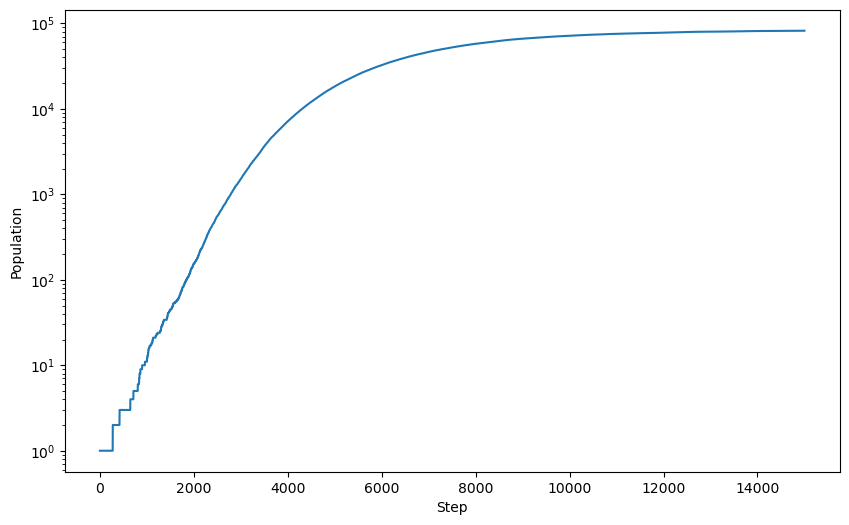

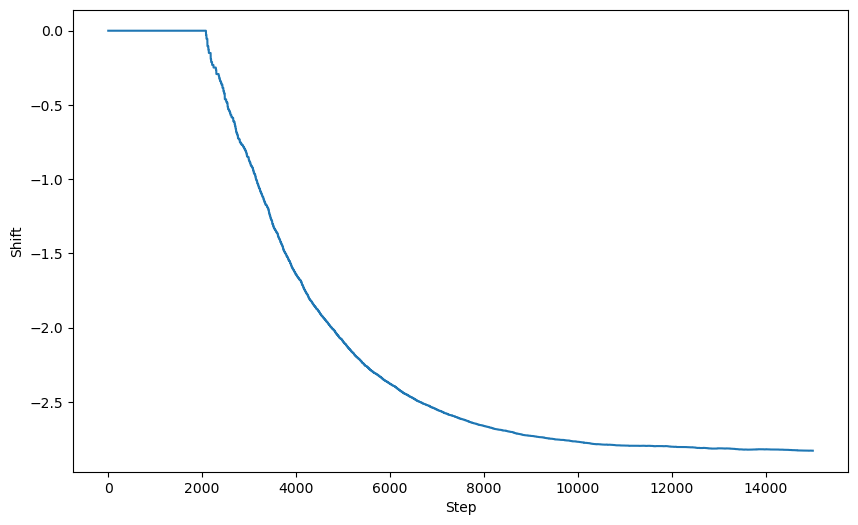

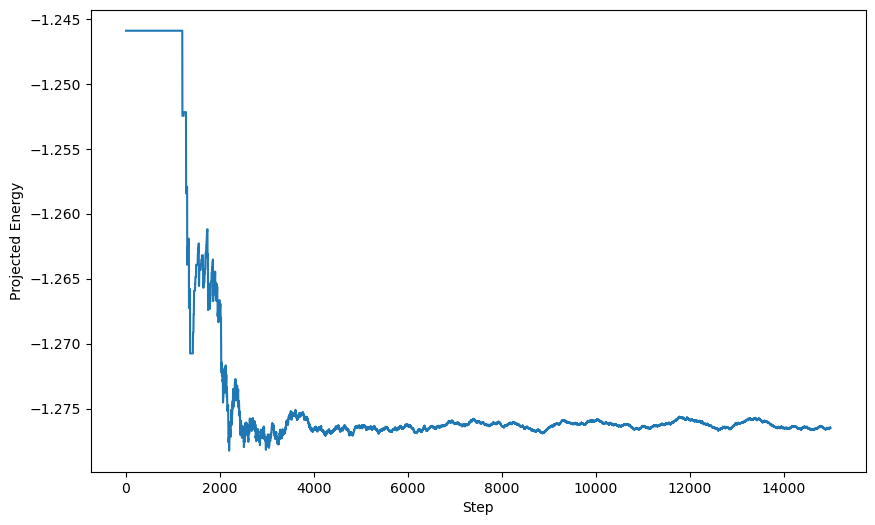

In [3]:
from pyscf import gto

# H3+分子の定義
mol = gto.M(
    atom = "H 0 0 0; H 1 0 0; H 0.5 0.866 0",
    basis = "sto-3g",
    charge = 1,
    spin = 0
)
E_est, E_fci, hist_population, hist_shift, hist_energy = FCIQMC(mol)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} Ha")
plot_result(hist_population, hist_shift, hist_energy)
